In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import lightgbm as lgb
import random

In [2]:
df = pd.read_csv('train.csv')

In [3]:
# X_code = df.drop(['target'], axis=1).values
# y = df['target'].values
# X_code_train, X_code_val, y_train, y_val = train_test_split(X_code, y, test_size= 0.15, random_state=0, stratify=y)

# X_train = X_code_train[:,1:].astype(np.float)
# code_train = X_code_train[:,0]
# X_val = X_code_val[:,1:].astype(np.float)
# code_val = X_code_val[:,0]

In [4]:
X_train = df.drop(['ID_code', 'target'], axis=1).values
y_train = df['target'].values

In [5]:
gbms = []
num_gbm  = 50
y_val_pred_gbm = []

for i in range(num_gbm):

    X_cv_train, X_cv_val, y_cv_train, y_cv_val = train_test_split(X_train, y_train, test_size= 0.175, random_state=i, stratify=y_train)

    lgb_cv_train = lgb.Dataset(X_cv_train, y_cv_train)
    lgb_cv_val = lgb.Dataset(X_cv_val, y_cv_val, reference=lgb_cv_train)

    params = {
        'objective': 'binary',
        'boost_from_average':False,
        'metric': 'auc',
        'boosting_type': 'gbdt', 
    'feature_fraction': 0.826977192958044, 'learning_rate': 0.02282076577563403, 'subsample': 0.9474956435517711, 'min_data_in_leaf': 82, 'min_sum_hessian_in_leaf': 0.0017853923506107412, 'bagging_fraction': 0.8404734128700382, 'bagging_freq': 1, 'min_gain_to_split': 0.9445989208456473, 'lambda_l1': 0.45734714204064286, 'lambda_l2': 0.39514949348019346, 'num_leaves': 22, 'max_bin': 140
    }

    gbm = lgb.train(params,
                    lgb_cv_train,
                    valid_sets=lgb_cv_val,
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval = 0)
    
    y_pred = gbm.predict(X_cv_train, num_iteration=gbm.best_iteration)
    fpr, tpr, thresholds = metrics.roc_curve(y_cv_train, y_pred)
    auc_train = metrics.auc(fpr, tpr)
    
    y_pred = gbm.predict(X_cv_val, num_iteration=gbm.best_iteration)
    fpr, tpr, thresholds = metrics.roc_curve(y_cv_val, y_pred)
    auc_val = metrics.auc(fpr, tpr)
    
    y_val_pred_gbm.append(y_pred)
    
    gbms.append(gbm)
    print("Iter:%d, AUC_train:%.5f, AUC_val:%.5f" % (i, auc_train, auc_val))

Iter:0, AUC_train:0.96527, AUC_val:0.89512
Iter:1, AUC_train:0.96481, AUC_val:0.89367
Iter:2, AUC_train:0.96442, AUC_val:0.89961
Iter:3, AUC_train:0.96520, AUC_val:0.89725
Iter:4, AUC_train:0.96556, AUC_val:0.89272
Iter:5, AUC_train:0.96505, AUC_val:0.89986
Iter:6, AUC_train:0.96573, AUC_val:0.89520
Iter:7, AUC_train:0.96463, AUC_val:0.89592
Iter:8, AUC_train:0.96540, AUC_val:0.89359
Iter:9, AUC_train:0.96514, AUC_val:0.89811
Iter:10, AUC_train:0.96506, AUC_val:0.90037
Iter:11, AUC_train:0.96571, AUC_val:0.89117
Iter:12, AUC_train:0.96546, AUC_val:0.89589
Iter:13, AUC_train:0.96537, AUC_val:0.89484
Iter:14, AUC_train:0.96577, AUC_val:0.89485
Iter:15, AUC_train:0.96529, AUC_val:0.89784
Iter:16, AUC_train:0.96498, AUC_val:0.90052
Iter:17, AUC_train:0.96495, AUC_val:0.89507
Iter:18, AUC_train:0.96485, AUC_val:0.89950
Iter:19, AUC_train:0.96525, AUC_val:0.89739
Iter:20, AUC_train:0.96539, AUC_val:0.89385
Iter:21, AUC_train:0.96539, AUC_val:0.89867
Iter:22, AUC_train:0.96549, AUC_val:0.8938

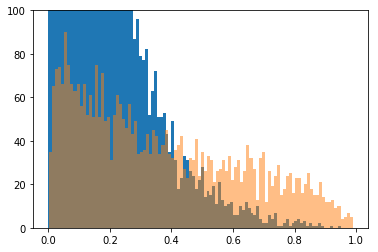

In [18]:
pos = y_cv_val == 1
neg = y_cv_val == 0
y_pred = gbm.predict(X_cv_val, num_iteration=gbm.best_iteration)
plt.hist(y_pred[neg], bins=100)
plt.hist(y_pred[pos], bins=100,alpha=0.5)
plt.ylim(0,100)
plt.show()

In [6]:
df_test = pd.read_csv('test.csv')
X_test = df_test.drop('ID_code', axis=1).values

In [7]:
y_test_pred_gbm = []

num = len(gbms)
for i in range(num):
    gbm = gbms[i]
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    y_test_pred_gbm.append(y_pred)
y_test_pred_gbm = np.array(y_test_pred_gbm)
y_test_pred_gmb_mean = (np.array(y_test_pred_gbm).prod(axis=0)) ** (1/num)

In [8]:
y_test_pred_gmb_mean.shape

(200000,)

In [9]:
se_y_test_pred = pd.Series(y_test_pred_gmb_mean, name='target')
df_sub = pd.concat([df_test['ID_code'], se_y_test_pred], axis=1)

In [10]:
df_sub.head()

,ID_code,target
0,test_0,0.098244
1,test_1,0.254415
2,test_2,0.213933
3,test_3,0.139685
4,test_4,0.044985


In [11]:
df_sub.to_csv('submission1.csv', index=False)

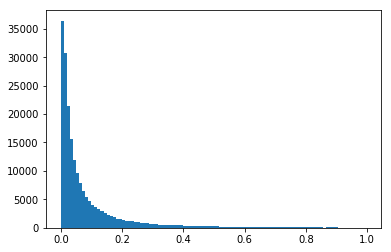

In [14]:
plt.hist(y_test_pred_gmb_mean, bins=100)
plt.show()